# Pipeline for a classification model

- the main goal is to fit the best category for a given handicraft product in the database;

In [1]:
import pandas as pd
import os
import dotenv
import pickle
from scipy import sparse
from datetime import date
from wordcloud import WordCloud
from matplotlib import pyplot as plt

from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

In [2]:
# load the environment varibables
dotenv.load_dotenv()

dataset_path = os.getenv("DATASET_PATH")
metrics_path = os.getenv("METRICS_PATH")
model_path = os.getenv("MODEL_PATH")
test_path = os.getenv("TEST_PATH")

stop_words = stopwords.words("portuguese")

In [3]:
# load the data
sample = pd.read_csv(dataset_path)

In [4]:
# quick glimpse at the dataset
sample.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,NaN,Outros
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração


In [5]:
# see the type and other information of each variable
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38000 entries, 0 to 37999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_id         38000 non-null  int64  
 1   seller_id          38000 non-null  int64  
 2   query              38000 non-null  object 
 3   search_page        38000 non-null  int64  
 4   position           38000 non-null  int64  
 5   title              38000 non-null  object 
 6   concatenated_tags  37998 non-null  object 
 7   creation_date      38000 non-null  object 
 8   price              38000 non-null  float64
 9   weight             37942 non-null  float64
 10  express_delivery   38000 non-null  int64  
 11  minimum_quantity   38000 non-null  int64  
 12  view_counts        38000 non-null  int64  
 13  order_counts       17895 non-null  float64
 14  category           38000 non-null  object 
dtypes: float64(3), int64(7), object(5)
memory usage: 4.3+ MB


- Taking a look at the correlation between the numerical variables and categories so one can have an insight for a possible relevant feature;

In [6]:
sample = pd.concat([sample, pd.get_dummies(sample.category)], axis = 1)

In [7]:
sample.corr().loc[sample.category.unique()].style.background_gradient(cmap = "inferno")

,product_id,seller_id,search_page,position,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,Bebê,Bijuterias e Jóias,Decoração,Lembrancinhas,Outros,Papel e Cia
Decoração,0.002909,0.035598,-0.083845,-0.015613,0.186105,0.188012,-0.129790,-0.123315,-0.042436,-0.059471,-0.257790,-0.086932,1.000000,-0.504968,-0.095690,-0.152460
Papel e Cia,-0.006709,0.017458,-0.049598,-0.021921,-0.050577,-0.035991,0.027196,0.093286,-0.022454,-0.004910,-0.131912,-0.044483,-0.152460,-0.258393,-0.048965,1.000000
Outros,0.000242,-0.013658,-0.051291,-0.009191,-0.016586,0.040026,-0.120809,-0.027826,-0.007140,-0.003384,-0.082793,-0.027919,-0.095690,-0.162177,1.000000,-0.048965
Bebê,-0.008351,0.005313,0.030482,0.002843,0.138312,0.008929,-0.033307,-0.088660,0.058541,0.049416,1.000000,-0.075215,-0.257790,-0.436908,-0.082793,-0.131912
Lembrancinhas,0.005992,-0.046786,0.099128,0.025358,-0.259269,-0.152270,0.206836,0.145289,0.004142,0.006051,-0.436908,-0.147335,-0.504968,1.000000,-0.162177,-0.258393
Bijuterias e Jóias,0.004581,0.026396,-0.028005,0.000451,0.086873,-0.026346,-0.142674,-0.037131,0.001339,0.016677,-0.075215,1.000000,-0.086932,-0.147335,-0.027919,-0.044483


- The word clouds ahead help us to understand how the textual features, like queries and title, behave for each category, in such way that make it an interesting feature to use in the model

In [8]:
def cloud_feature(feature: str):
    """ a function to loop over and create wordclouds for each label of the dataset """
    for category in sample.category.unique():
        words = " ".join(word for word in sample.query(f"category == '{category}'")[feature].dropna())

        cloud = WordCloud(
            stopwords = stop_words,
            background_color = "white",
            colormap = "inferno",
            width = 800,
            height = 800
        ).generate(words)

        plt.figure(facecolor = 'white')
        plt.title(category, fontweight = "bold")
        plt.axis("off")
        plt.imshow(cloud, interpolation = "bilinear")
        plt.tight_layout()
        plt.show()

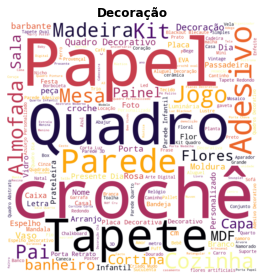

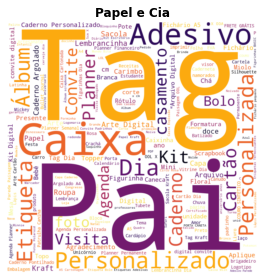

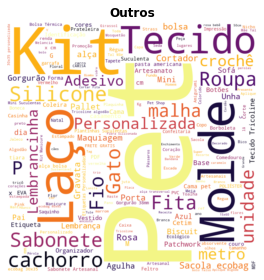

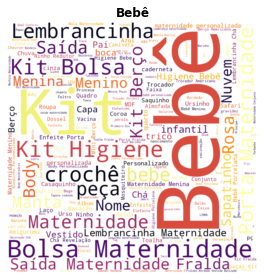

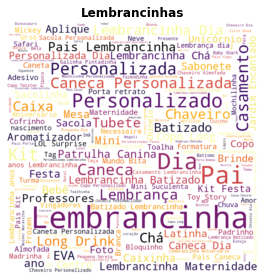

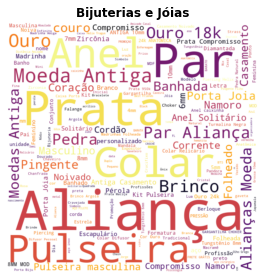

In [9]:
cloud_feature("title")

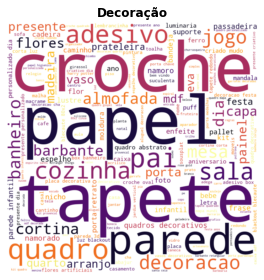

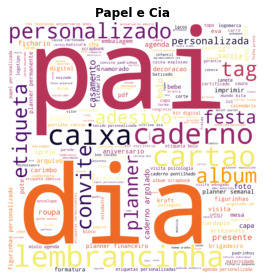

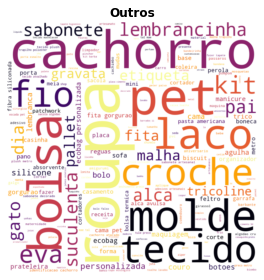

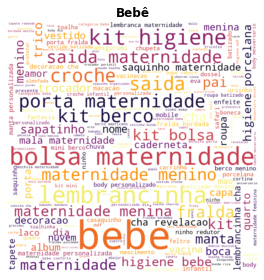

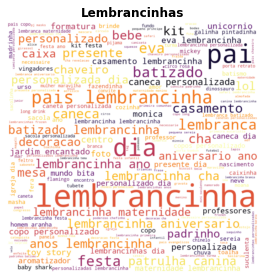

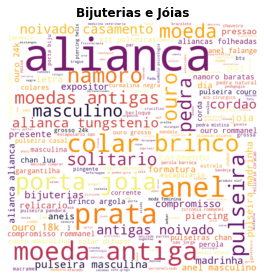

In [10]:
cloud_feature("query")

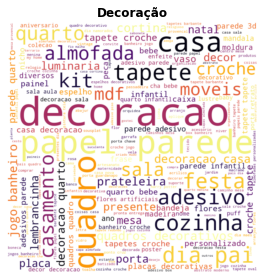

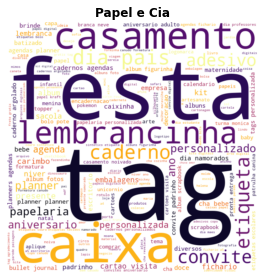

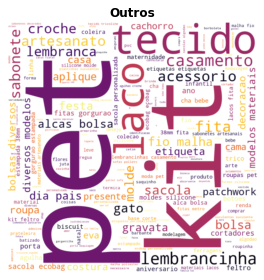

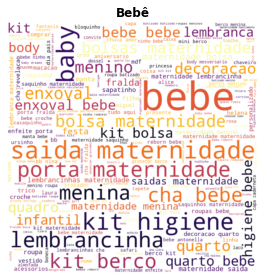

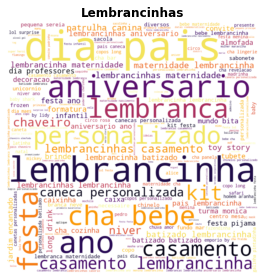

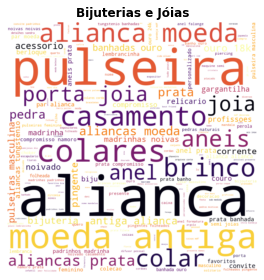

In [11]:
cloud_feature("concatenated_tags")

# Preprocessing

- using holdout to evalute the model;
- encode the label to have numerical values for each category;
- bag of words to process the `concatenated_tags` and `title` features;

In [12]:
# define the features and label
X = sample[["concatenated_tags", "title"]]
y = sample["category"]

In [13]:
X.fillna("", inplace = True)
X = X.apply(lambda x: x.str.lower())

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:4459: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [14]:
# encode the label (dependent variable)
enc = LabelEncoder()

enc.fit(y)

y_enc = enc.transform(y)

In [15]:
count_vectorizer = CountVectorizer(stop_words = stop_words)

X_tags = count_vectorizer.fit_transform(X.concatenated_tags)

X_title = count_vectorizer.transform(X.title)

X_array = sparse.hstack((X_tags, X_title))

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_array, y_enc, train_size = 0.8)

# Modelling
- given the fact that the dependent variable (category) is of type object (categorical, if you will) we might use the logistic regression;

In [17]:
logistic = LogisticRegression()

model = logistic.fit(X_train, y_train)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
y_pred = model.predict(X_val)

# Metrics

In [19]:
metrics_report = metrics.classification_report(y_val, y_pred, target_names = enc.classes_)
print(metrics_report)

                    precision    recall  f1-score   support

              Bebê       0.88      0.87      0.88      1449
Bijuterias e Jóias       0.96      0.87      0.91       183
         Decoração       0.89      0.90      0.90      1755
     Lembrancinhas       0.89      0.94      0.92      3437
            Outros       0.87      0.70      0.78       237
       Papel e Cia       0.85      0.71      0.77       539

          accuracy                           0.89      7600
         macro avg       0.89      0.83      0.86      7600
      weighted avg       0.89      0.89      0.89      7600



In [20]:
with open(metrics_path, "w") as file:
    file.write(f"Model: {model}\ndate: {date.today()}\n\n")
    file.write(f"Metrics:\n{metrics_report}")

In [21]:
# save the model
with open(model_path, "wb") as file:
    pickle.dump(model, file)

# Test

- applying the model to the test dataset;

In [22]:
test_sample = pd.read_csv(test_path)

In [23]:
test_sample.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,4973768,2484177,lembrancinhas de 15 anos,5,8,Lembrancinha 15 anos - Lembrancinha de 15 anos,15 anos,2019-02-02 10:28:57,14.180000,10.0,1,13,91,NaN,Lembrancinhas
1,14180109,3191400,prateleira,1,32,Trio de Nichos Prateleira,prateleiras decoracao gaveteiros nichos pratel...,2017-08-23 22:17:01,97.060005,7492.0,1,1,729,32.0,Decoração
2,5058490,1414443,lembrancinhas vingadores,2,19,Caixa meia bala Vingadores,vingadores super herois,2017-05-28 04:26:03,11.580000,0.0,1,13,92,NaN,Lembrancinhas
3,576188,9188811,sacolinha galinha pintadinha,1,6,Sacolinha Galinha Pintadinha,sacolinhas galinha pintadinha sacolinhas perso...,2017-02-14 10:19:28,13.390000,8.0,1,15,34,NaN,Lembrancinhas
4,5190417,2497208,vaso de barro atacado,1,23,30 Mini Vaso 6cm Cerâmica Lembrancinha casamen...,cha bebe lhama mini vasos c adesivos,2018-10-19 00:22:33,11.470000,2009.0,1,39,741,NaN,Lembrancinhas


In [24]:
X_test = test_sample[["concatenated_tags", "title"]]
y_test = test_sample["category"]

In [25]:
X_test.fillna("", inplace = True)
X_test = X_test.apply(lambda x: x.str.lower())

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:4459: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [26]:
y_test_enc = enc.transform(y_test)

In [27]:
X_test_tags = count_vectorizer.transform(X_test.concatenated_tags)

X_test_title = count_vectorizer.transform(X_test.title)

X_test_array = sparse.hstack((X_test_tags, X_test_title))

In [28]:
y_test_pred = model.predict(X_test_array)

In [30]:
print(metrics.classification_report(y_test_enc, y_test_pred, target_names = enc.classes_))

                    precision    recall  f1-score   support

              Bebê       0.90      0.91      0.90        95
Bijuterias e Jóias       1.00      1.00      1.00        11
         Decoração       0.91      0.90      0.91       122
     Lembrancinhas       0.93      0.96      0.94       230
            Outros       0.90      0.60      0.72        15
       Papel e Cia       0.88      0.81      0.85        27

          accuracy                           0.92       500
         macro avg       0.92      0.86      0.89       500
      weighted avg       0.92      0.92      0.91       500

